## Setup

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
from math import ceil
from google.colab import files
df = pd.read_csv(r'https://raw.githubusercontent.com/fielddaylab/opengamedata/master/jupyter/lakeland_data/lakeland_no_continue_through_window_3',index_col='sessID')

In [0]:
features = list(df.columns)
def scatter(idx_xy_list,suptitle=None,download=False,download_name=None, **kwargs):
  nrows, ncols = ceil(len(idx_xy_list)/2), 2
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
  plt.suptitle(suptitle)
  for i,(index_x, index_y) in enumerate(idx_xy_list):
    r,c = i//2, i%2
    ax = axes[r,c] if nrows > 1 else axes[c]
    df.plot.scatter(features[index_x], features[index_y],ax=ax,**kwargs)
  if download:
    download_name = download_name or suptitle+'.png' or 'lakeland_scatter.png'
    plt.savefig(download_name)
    files.download(download_name) 

##Graph
Usage: scatter(idx_xy_list,suptitle=None,download=False,download_name=None, **kwargs)
- **idx_xy_list** - a list of (index_x,index_y) that refer to the index of the features to be used on the x and y axes respectively. The index numbers can be found on the google sheets below.
- **suptitle** - title for graph (none if not set)
- **download** - set to True if you would like to download the graph
- **download_name** - what to call your download (include .png or .jpg etc.). Defaults to {suptitle}.png or lakeland_scatter.png.
- **kwargs** - Any other arguments will be sent to each individual scatter function

where kwargs are any arguements to be sent to plt.scatter.

Please refer to https://docs.google.com/spreadsheets/d/1CYMbcknoBebqHcvU_QEegwlLpB4iqJAGCs3yu1AwrjA/edit#gid=551340614 for indices to use.

[(435, 448), (436, 448), (437, 448), (438, 448), (439, 448), (440, 448), (441, 448), (442, 448)]


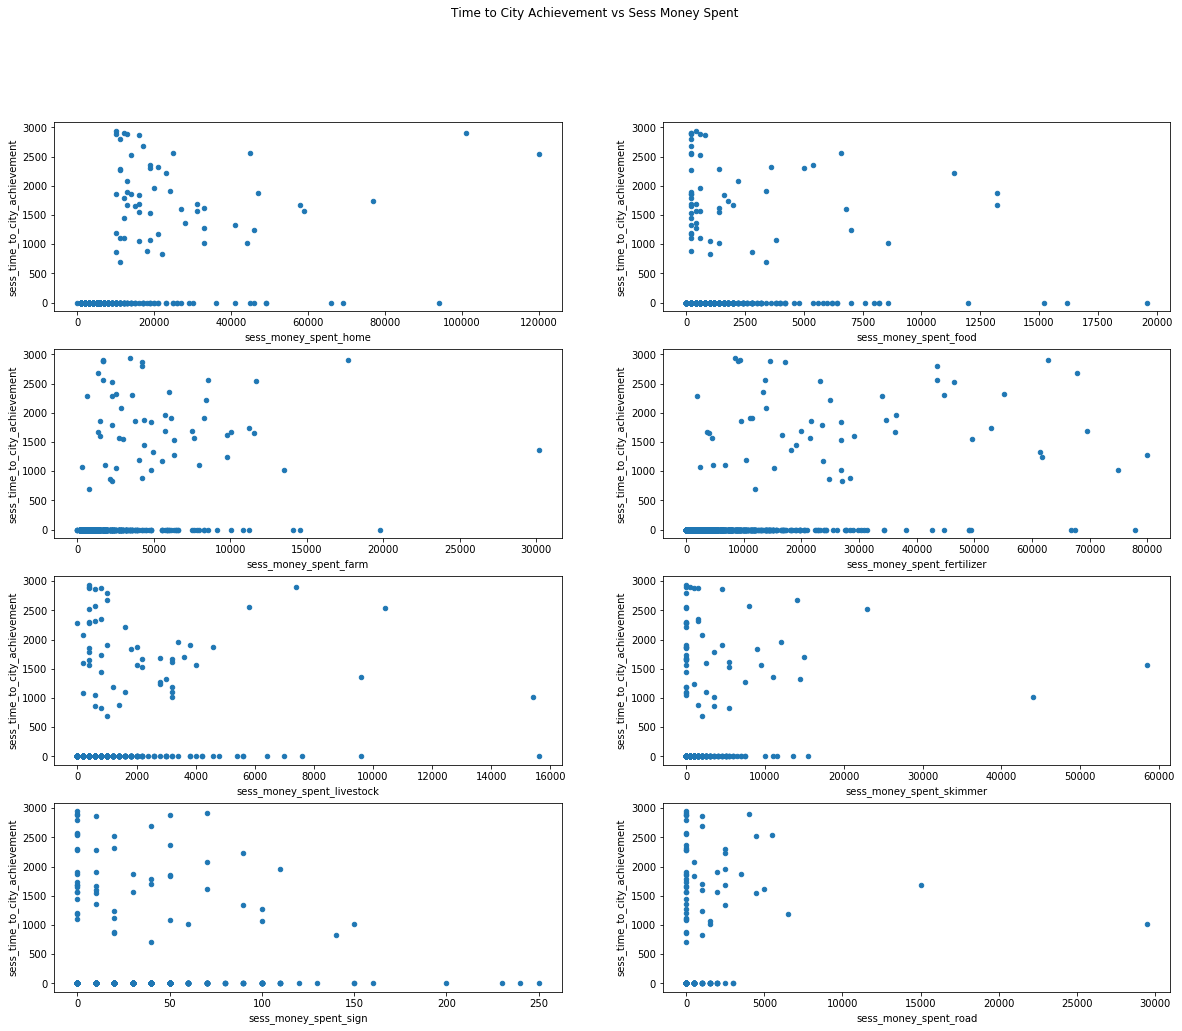

In [0]:
money_spent_idxs = range(435,443)
xy_pairs = [(x,448) for x in money_spent_idxs]
print(xy_pairs)
scatter(xy_pairs,figsize=(20,16),suptitle='Time to City Achievement vs Sess Money Spent', download=True)

----
----
**Note**: Stuff below here is stuff that I am still expirementing with and is not quite too usable yet.
## Clustering on 2 Features


In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

In [0]:
dropped_df = df.drop(['language','persistentSessionID'], axis=1)
filled_mat = dropped_df.fillna(0).to_numpy()
def kmeans(x_index,y_index, num_clusters=3,cluster_range=None,fullkmeans = False):
  cluster_range = cluster_range or [num_clusters]
  xy_names = (features[x_index], features[y_index])
  X = df[[features[x_index], features[y_index]]].dropna().to_numpy()
  for clusters in cluster_range:
    if fullkmeans:
      kmeans = KMeans(clusters).fit(filled_mat)
    else:
      kmeans = KMeans(n_clusters=clusters).fit(X)
    plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis')
    xlabel, ylabel = xy_names
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
  

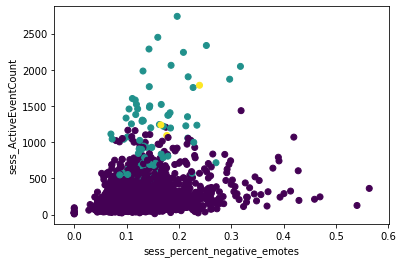

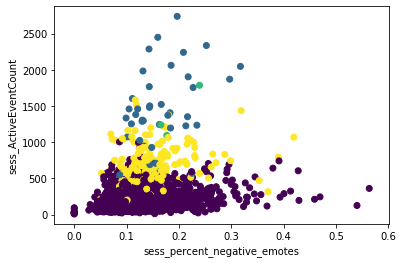

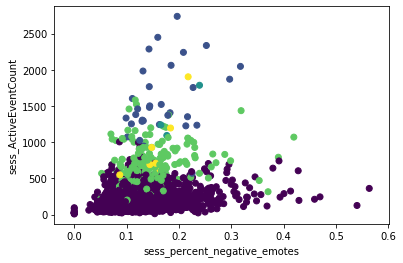

In [0]:
kmeans(623,641,fullkmeans=True,cluster_range=range(3,6))

## Clustering on Multiple Features

In [0]:
def multifeature_kmeans(feature_indices, x_index, y_indices,clustering_method=None, suptitle=None,download=False,download_name=None, num_clusters=3, **kwargs):
  # if dependent_var_idx not in feature_indices:
  #   print('dependent_var_idx not in feature_indices')
  #   return
  if x_index not in feature_indices:
    print('x_index not in feature_indices')
    return

  tdf = df[[features[idx] for idx in feature_indices]].fillna(0)
  feature_names = [features[idx] for idx in feature_indices]
  independent_var_name = features[x_index]
  dependent_var_names = [features[idx] for idx in y_indices]

  X = tdf.to_numpy()
  clustering_method = clustering_method or KMeans(n_clusters=num_clusters)
  clustering = clustering_method.fit(X)

  ncols = 8
  nrows = ceil(len(y_indices)/ncols)
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(ncols*5,nrows*3+2))
  plt.suptitle(suptitle)
  for i,(x_idx, y_idx) in enumerate([(x_index,d) for d in y_indices]):
    xname,yname = features[x_idx], features[y_idx]
    x,y = tdf[xname].data, tdf[yname].data
    r,c = i//ncols, i%ncols
    ax = axes[r,c] if nrows > 1 else axes[c]
    ax.scatter(x, y, c=clustering.labels_, cmap='viridis')
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
  if download:
    download_name = download_name or suptitle+'.png' or 'lakeland_clusters.png'
    plt.savefig(download_name)
    files.download(download_name) 
    print('here')

### Find Episilon

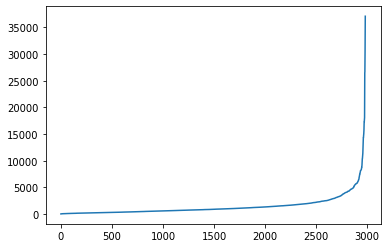

In [0]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
X = df[[features[idx] for idx in range(423,526)]].fillna(0).to_numpy()
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [0]:
!pip install --upgrade hdbscan
import hdbscan

     |████████████████████████████████| 4.4MB 9.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.24-cp36-cp36m-linux_x86_64.whl size=2360732 sha256=ece2c7ece5a766e5281dd38efc0a0ad72563408e2c6eb5051191e6acc297cb6a
  Stored in directory: /root/.cache/pip/wheels/6a/5a/ab/a3247c72fa70b67699d5f8be94bd0c2d3d38864825d773b9f1
Successfully built hdbscan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: FutureWarning: Series.data is deprecated and will be removed in a future version


here


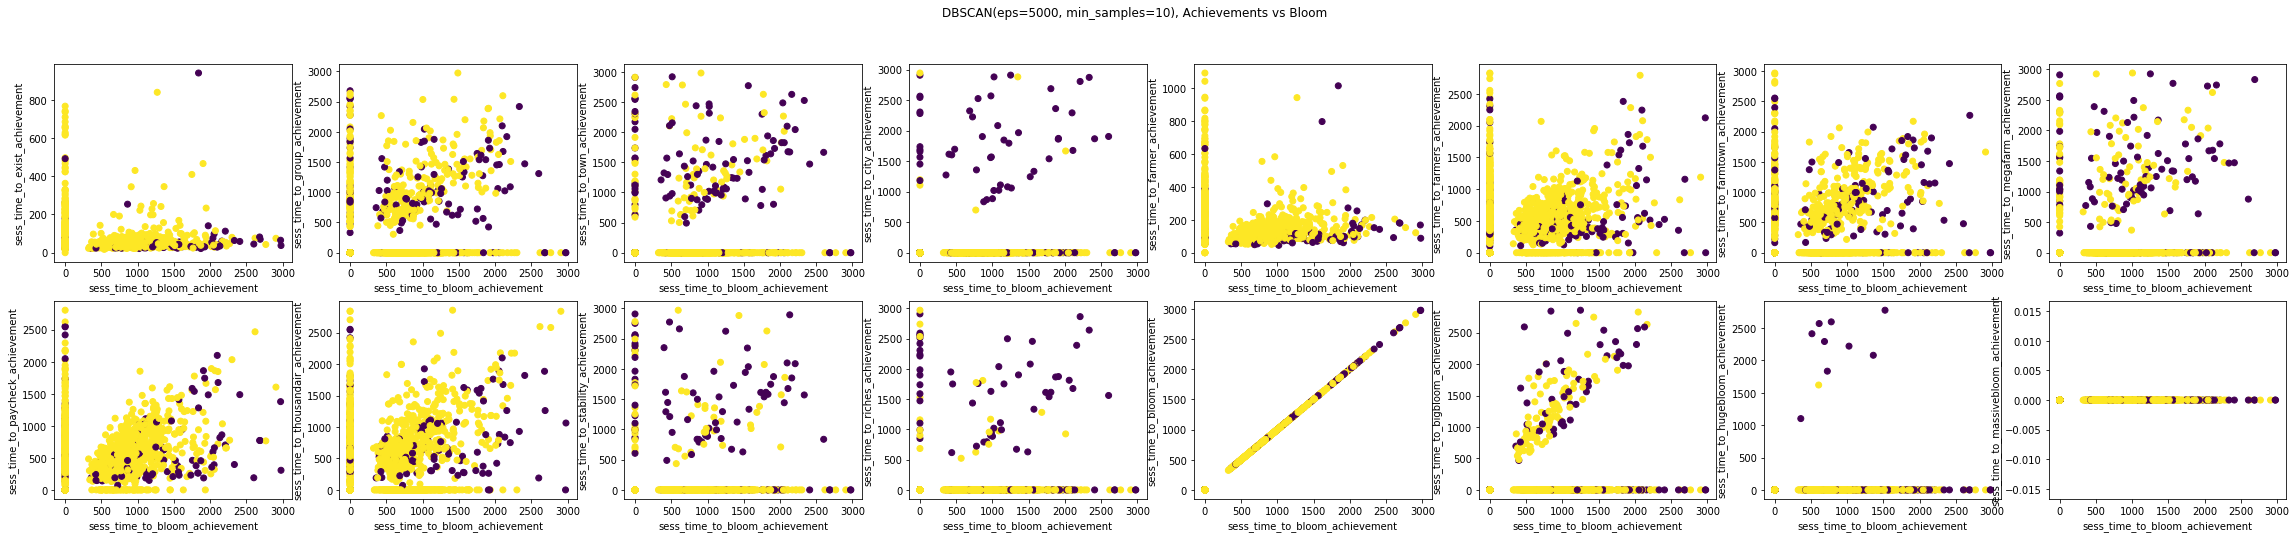

In [0]:
from sklearn.cluster import DBSCAN
chosen_features = range(423,526)
for eps in [5000]:
  multifeature_kmeans(chosen_features, y_indices=range(445,461),x_index=457,
                    suptitle=f'DBSCAN(eps={eps}, min_samples=10), Achievements vs Bloom',clustering_method=DBSCAN(eps=eps, min_samples=10),download=True)

## PCA

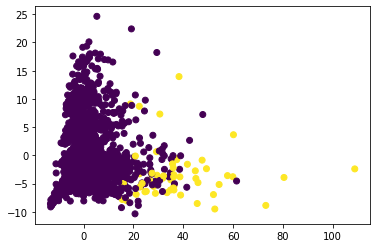

In [0]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipeline = make_pipeline(StandardScaler(), PCA(n_components=2))
projected = pipeline.fit_transform(filled_mat)
plt.scatter(projected[:,0], projected[:,1],c=KMeans(2).fit(filled_mat).labels_)

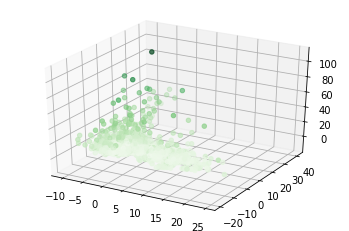

In [35]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipeline = make_pipeline(StandardScaler(), PCA(n_components=3))
projected = pipeline.fit_transform(filled_mat)

from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
zdata = projected[:,0]
xdata = projected[:,1]
ydata = projected[:,2]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');